In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy

In [2]:
def saturation_temperature(pressure):
    pvc = [-51.574, 0.20636, -0.29381e-3, 0.2231e-6, -0.86184e-10, 1.3299e-14]
    tlo = 400.0
    thi = 1800.0
    for j in range(100):
        temp = (tlo+thi)/2.0
        pv = pvc[5]
        for i in range(4,-1,-1):
            pv = temp*pv + pvc[i]
        pv = 10.0*math.exp(pv)  
        #print(j,temp,pv,pressure)
        if (abs(pv-pressure) < 0.001):
            break
        if (pv < pressure):
            tlo = temp
        else:
            thi = temp
    return temp

In [3]:
def fmax(fmx,spec_heat_ratio, inlet_mach):
    phi = (.3403/fmx**0.255)**2
    if (inlet_mach > 1.0):
        phi = (1.0286*math.exp(2.4938*fmx))**2
    for i in range(50):
        checkval = (spec_heat_ratio+1.0)*phi/2./(1.0+(spec_heat_ratio-1.0)/2.*phi)
        f = (1.0-phi)/spec_heat_ratio/phi+(spec_heat_ratio+1.0)/2./spec_heat_ratio*math.log((spec_heat_ratio+1.0)*phi/2./(1.0+(spec_heat_ratio-1.0)/2.*phi))-fmx
        if (abs(f)<0.0001):
            break
        df = (spec_heat_ratio+1.0)/(2.*spec_heat_ratio*phi*(1.0+(spec_heat_ratio-1.0)/2.*phi)) - 1.0/spec_heat_ratio/phi**2
        df1 = (spec_heat_ratio+1.0)/(2.*spec_heat_ratio*phi*(1.0+(spec_heat_ratio-1.0)/2.*phi))
        df2 = 1.0/spec_heat_ratio/phi**2
        phi_new = phi - f/df
        if (phi_new <= 0.0):
            phi_new = 1e-6
        if (inlet_mach < 1.0 and phi_new > 1.0):
            phi_new = 0.9999
        if (inlet_mach >= 1.0 and phi_new < 1.0):
            phi_new = 1.0001
        phi = phi_new
    exit_mach = math.sqrt(phi)
    return exit_mach

In [4]:
def pressure_ratio(mach, spec_heat_ratio):
    pressr = math.sqrt((spec_heat_ratio+1.0)/2./(1.0+(spec_heat_ratio-1.0)/2.*mach**2))/mach
    return pressr

In [5]:
def flmax(mach, spec_heat_ratio):
    fl = (1.0-mach**2)/spec_heat_ratio/mach**2+(spec_heat_ratio+1.0)/2./spec_heat_ratio*math.log((spec_heat_ratio+1.0)*mach**2/2./(1.0+(spec_heat_ratio-1.0)/2.*mach**2))
    return fl

In [6]:
def friction(reynolds):
    if (reynolds>2000 and reynolds <= 20000):
        f= 0.079/reynolds**0.25
    elif (reynolds>20000):
        f = 0.046/reynolds**.2
    else:
        f = 16.0/reynolds
    return f

In [7]:
def fluid_properties(temp):
    #coefficients for potassium
    pvc = [-51.574, 0.20636, -0.29381e-3, 0.2231e-6, -0.86184e-10, 1.3299e-14]
    rholc = [940.43, -0.42954, 0.42662e-3, -0.42981e-6, 0.19884e-9, -3.4521e-14]
    mulc = [0.0016193, -0.55722e-5,0.87656e-8, -0.70683e-11, 2.8447e-15, -4.5263e-19]
    muvc = [0.54558e-5, 0.69661e-8, 0.30725e-10, -3.9354e-14, 1.9365e-17, -3.5469e-21]
    sigc = [0.13127, -6.6e-5, 2.7756e-17, -5.7598e-20, 1.7371e-23, -5.0487e-27]
    hfgc = [2226400.0, 135.36, -0.60104, 0.15934e-3, 0.42749e-7, -0.20228e-10]
    rhovc = [-0.60872e2, 0.19765, -0.28146e-3, 0.21319e-6, -0.82191e-10, 0.1268e-13]
    ctlc = [0.68968e2, -0.36091e-1, -0.35049e-4, 0.60981e-7, -0.34141e-10, 0.66235e-14]
    mwc = 39.1
    rkc = [1.7402, -0.1238e-3]
    pv = pvc[5]
    rhol = rholc[5]
    mul = mulc[5]
    muv = muvc[5]
    sig = sigc[5]
    hfg = hfgc[5]
    rhov = rhovc[5]
    cfluid = ctlc[5]
    for i in range(4,-1,-1):
        pv = temp*pv + pvc[i]
        rhol = temp*rhol + rholc[i]
        mul = temp*mul + mulc[i]
        muv = temp*muv + muvc[i]
        sig = temp*sig + sigc[i]
        hfg = temp*hfg + hfgc[i]
        rhov = temp*rhov + rhovc[i]
        cfluid = temp*cfluid + ctlc[i]
    mw = mwc
    rk = rkc[0]+temp*rkc[1]
    pv = 10.0*math.exp(pv)
    rhol = 0.001*rhol
    muv = 10.0*muv
    hfg = 0.001*hfg
    sig = 1000.0*sig
    rhov = 0.001*math.exp(rhov)
    mul = 10.0*mul
    return pv, rhol, mul, muv, sig, hfg, rhov, cfluid, mw, rk

In [8]:
def dpe_evap(q_total):
    q = q_total / 2.0
    qhfg = q/hfg
    qhfgt = q_total/hfg
    dple = 6.0*mu_l*qhfg*le/(math.pi*rv*a**3*rho_l)
    dv = 2*rv #math.sqrt(4.0*av/math.pi)  #diameter
    vy = qhfgt/rho_v/av
    reyv = 4.0*qhfgt/math.pi/mu_v/dv
    rrn = qhfgt/2./math.pi/le/mu_v
    psi = 0.61*rrn+0.61*rrn/(3.6+rrn) # velocity profile correction factor C
    avis = 16.0/reyv*le/dv
    beta= avis*psi
    dpve = avis*(qhfgt/av)**2/rho_v
    dpie = (qhfgt/av)**2*beta/rho_v
    return dpie,dpve,dple

In [9]:
def dpa_adiab(temp, q_total):
    qhfg = q_total/hfg
    dpla = 6.0*mu_l*qhfg*la/(math.pi*rv*a**3*rho_l)
    rm1 = qhfg/av/rho_v/math.sqrt(rbar*temp/mw)  #mach number at exit
    rey = 4.0*qhfg/math.pi/2.0/rv/mu_v
    f = friction(rey)
    if (rm1 > 0.2):
        fl2 = flmax(rm1,rk)-4.0*f*la/2.0/rv
        rm2 = 1.0
        if (fl2 > 0.0):
            rm2 = fmax(fl2,rk,rm1)
    else:
        rm2 = rm1
    if (rm2 > 0.3):
        pr = pressure_ratio(rm1,rk)/pressure_ratio(rm2,rk)
        if (pr <1.0 or pr > 2.08):
            pr = 2.08
        pa2 = pv/pr
        dpa = (pv-pa2)/2.0
    else:
        dpa = 2.0*f*la/(2.0*rv)*qhfg**2/rho_v/av**2
        pa2 = pv-dpa
    tbc = saturation_temperature(pa2)
    return dpla, dpa

In [10]:
def dpc_cond(q_total):
    qhfg = q_total/hfg
    qa = q1_array[i]
    qb = q1_array[i+1]
    lc1 = lc/cinc
    cfract = (distance[i]-le-la)/lc
    qrad = qa-qb
    qhfg1 = (qa+qb)/(2.0*hfg)
    dplc = 6.0*mu_l*qhfg1*lc1/(math.pi*rv*a**3*rho_l)
    rreyc = -qhfg/2.0/math.pi/lc1/mu_v
    reyc = 4.0*qhfg1/math.pi/2.0/rv/mu_v
    vci = qa/hfg/av/rho_v
    vcii = qb/hfg/av/rho_v
    #Busse correction not yet added, check Reynolds
    f = friction(reyc)
    dpvc = 4.0*f*(lc1/2.0)*rho_v*vci**2/(4.0*rv)
    lparam = (2.0*le+4.0*la)/lc
    recov = (rreyc+2.0)/(1.23*rreyc-lparam)
    dpic = -(vci**2-vcii**2)*rho_v*recov
    return dpic, dpvc, dplc

In [11]:
def sonic_limit(temp, q_total):
    pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk = fluid_properties(temp)
    qs = q_total/hfg
    for i in range(10):
        reys = 4.0*qs/math.pi/2.0/rv/mu_v
        f = friction(reys)
        fli = 4.0*f*la/2.0/rv
        rmis = fmax(fli,rk,0.0)
        w1 = rmis*math.sqrt(rbar*temp/mw)
        rreys = reys*rv/4.0/le
        ab = 1.22+1.22/(3.6+rreys)
        dpvs = 8.0*mu_v*w1/rv**2*le/2.0
        dpis = rho_v*ab*w1**2
        pos = pv + dpis + dpvs
        te_sonic = saturation_temperature(pos)
        q_sonic = math.sqrt(rho_v*pv)*av*hfg*rmis
        pci = pv/pressure_ratio(rmis,rk)
        tc_sonic = saturation_temperature(pci)
        if abs(q_sonic-qs*hfg)<1.0:
            break
        else:
            qs = q_sonic/hfg
    return q_sonic, pci, tc_sonic

In [12]:
def entrainment_limit(temp,pci,tc_sonic):
    pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk = fluid_properties(temp)
    tcie = tc_sonic
    p2e = pci
    z = wire_radius
    for i in range(10):
        rhov1 = mw*p2e/(rbar*tcie)
        w2e = math.sqrt(2.0*math.pi/z/rhov1)
        rm2e = w2e/math.sqrt(rk*rbar/mw*tcie)
        if rm2e > 1.0:
            rm2e = 1.0
        reye = 2.0*rv*rhov1*w2e/mu_v
        f = friction(reye)
        fl2e = 4.0*f*la/2.0/rv
        fl1e = fl2e + flmax(rm2e,rk)
        rm1e = fmax(fl1e,rk,0.0)
        p2e = pv*pressure_ratio(rm2e,rk)/pressure_ratio(rm1e,rk)
        tcie2 = saturation_temperature(p2e)
        if abs(tcie2-tcie)<1.0:
            break
        else:
            tcie = tcie2
    qentrn = math.sqrt(2.0*math.pi*rhov1*sig/z)*hfg*av
    return qentrn

In [13]:
def boiling_limit(temp):
    pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk = fluid_properties(temp)
    rnuc = 0.00127  #nucleation site radius
    dtboil = 2.0*sig*temp/(rho_v*hfg*rnuc)
    rkw = eff_pore_radius*cfluid + (1.0-eff_pore_radius)*k_wick
    a1 = 2.0*math.pi*radius_in*le
    dtloq = a/(a1*rkw)
    alv = 2.0*math.pi*(radius_in-a)*le*eff_pore_radius
    r = rbar/mw
    dtlv = (2.0*math.pi)**0.5*r**1.5*temp**2.5/(alv*pv*hfg**2)
    qboil = dtboil/(dtloq+dtlv)
    return qboil

In [14]:
t_sink = 300
q_total = 15122 #total power in watts
le = 50.0
la = 20.0
lc = 50.0
cinc = 10 #increment in condenser
ainc = 6
einc = 10
theta = 0.0  #inclination angle
radius_in = 1.75 
wick_porosity = 0.6
k_wick = 0.13
k_wall = 0.13
nucl_radius = 0.00127
radius_out = 1.9
screen_thickness = 0.1
wire_radius = 0.002
annulus_thickness = 0.1
eff_pore_radius = 0.004
h_sink = 0.05
rbar = 8.314e7
grav = 980.0

a = annulus_thickness
cond_area = 2*math.pi*lc*radius_out/cinc #condenser area for each mesh, acondi
abd = math.log(radius_out/radius_in)
abc = math.log(radius_in/(radius_in-annulus_thickness))

icondb = einc+ainc+1 #index of beginning of condenser
iconde = einc+ainc+cinc #index of end of condenser
iadiab = einc+ainc

In [15]:
thigh = 1800
tlow = 400

value_thing = 1500
qe_array = [value_thing,value_thing,value_thing,value_thing,value_thing,value_thing,value_thing,value_thing,value_thing,value_thing]
q_total = sum(qe_array)

total_mesh = cinc+ainc+einc+1
distance = np.zeros(total_mesh)
q1_array = np.zeros(total_mesh)
tempx = np.zeros(total_mesh)
for i in range(einc+1):
    distance[i] = i*le/einc
for i in range(einc+1,einc+ainc+1):
    distance[i] = le + (i-(einc))*la/ainc
for i in range(einc+ainc+1,total_mesh):
    distance[i] = le + la + (i-(einc+ainc))*lc/cinc
    
#only once
rv = radius_in - annulus_thickness - screen_thickness
b = (radius_in+rv+screen_thickness)*math.pi
av = math.pi*rv*rv
rh = a*b/(a+b)
al = a*b


for k in range(20):
    
    tguess = (thigh+tlow)/2  # guess temperature at the end of evaporator, iterate until q in equals q out
    
    ### EVAPORATOR
    pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk = fluid_properties(tguess)
    rcond = (1/h_sink+radius_out*abd/k_wall+radius_in/cfluid*abc)/cond_area  #heat transfer from inside to outside
    #conduction heat sink
    tempx[einc]= tguess
    q1_array[einc]= q_total
    for j in range(0,einc):
        i = einc-1-j
        q1_array[i] = q1_array[i+1]-qe_array[i]
        tempx[i] = ((qe_array[i]/(cfluid*cond_area))*(distance[i+1]-distance[i])) + tempx[i+1]
    
    ### ADIABATIC
    for i in range (einc+1,iadiab+1):  # boundary 6 and 8
        q1_array[i] = q1_array[i-1]
        tempx[i] = tempx[i-1]
    #tempx[icondb-1] = saturation_temperature(pvap[icondb-1])
    #q1_array[icondb-1] = q_total
    
    ### CONDENSOR - convective coupling
    qcond = 0.0
    for i in range(icondb-1,iconde):
        qout = (tempx[i]-t_sink)/rcond   #heat out in mesh i
        if (qout < 0.0):    #if t_sink > tempx, guess temperature is too high
            print('ierror 2')
            thigh = tguess
            break
        qcond = qcond + qout
        q1_array[i+1] = q1_array[i]-qout
        ### end of dpcond
        tempx[i+1] = ((-1*qout/(cfluid*cond_area))*(distance[i+1]-distance[i])) + tempx[i]
        
        pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk = fluid_properties(tempx[i+1])
        #conduction heat sink
        rcond = (1/h_sink+radius_out*abd/k_wall+radius_in/cfluid*abc)/cond_area  #heat transfer from inside to outside
    if abs((qcond-q_total)/q_total)<0.001:
        print('Converged ', k, qcond, q_total, tguess)
        break
    elif (qcond > q_total):
        thigh = tguess
    else:
        tlow = tguess
    print('iteration ', k, qcond,q_total, tguess)
    
for i in range(len(tempx)):
    print(distance[i],tempx[i],q1_array[i])

iteration  0 21716.097334976977 15000 1100.0
iteration  1 12327.503484051605 15000 750.0
iteration  2 17049.101049446057 15000 925.0
iteration  3 14694.36726034198 15000 837.5
iteration  4 15873.327018373973 15000 881.25
iteration  5 15284.234931918765 15000 859.375
Converged  6 14989.396825263337 15000 848.4375
0.0 883.750115138472 0.0
5.0 880.2188536246248 1500.0
10.0 876.6875921107776 3000.0
15.0 873.1563305969304 4500.0
20.0 869.6250690830832 6000.0
25.0 866.093807569236 7500.0
30.0 862.5625460553888 9000.0
35.0 859.0312845415416 10500.0
40.0 855.5000230276944 12000.0
45.0 851.9687615138472 13500.0
50.0 848.4375 15000.0
53.333333333333336 848.4375 15000.0
56.666666666666664 848.4375 15000.0
60.0 848.4375 15000.0
63.333333333333336 848.4375 15000.0
66.66666666666667 848.4375 15000.0
70.0 848.4375 15000.0
75.0 844.8030865289245 13456.183382274077
80.0 841.2038466463207 11922.596763971424
85.0 837.6392619673765 10399.141150222804
90.0 834.1088250542846 8885.719004943674
95.0 830.61203

In [16]:
print(q1_array)

[0.00000000e+00 1.50000000e+03 3.00000000e+03 4.50000000e+03
 6.00000000e+03 7.50000000e+03 9.00000000e+03 1.05000000e+04
 1.20000000e+04 1.35000000e+04 1.50000000e+04 1.50000000e+04
 1.50000000e+04 1.50000000e+04 1.50000000e+04 1.50000000e+04
 1.50000000e+04 1.34561834e+04 1.19225968e+04 1.03991412e+04
 8.88571900e+03 7.38223422e+03 5.88859209e+03 4.40469926e+03
 2.93046374e+03 1.46579485e+03 1.06031747e+01]


In [17]:
tempx

array([883.75011514, 880.21885362, 876.68759211, 873.1563306 ,
       869.62506908, 866.09380757, 862.56254606, 859.03128454,
       855.50002303, 851.96876151, 848.4375    , 848.4375    ,
       848.4375    , 848.4375    , 848.4375    , 848.4375    ,
       848.4375    , 844.80308653, 841.20384665, 837.63926197,
       834.10882505, 830.61203911, 827.14841766, 823.7174843 ,
       820.3187724 , 816.95182481, 813.61619365])

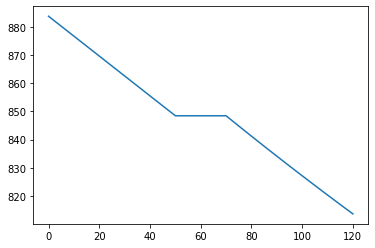

In [18]:
plt.plot(distance,tempx)

In [19]:
tempx2 = tempx

In [23]:
t_sink = 300
q_total = 15122 #total power in watts
le = 50.0
la = 20.0
lc = 50.0
cinc = 10 #increment in condenser
ainc = 6
einc = 10
valuee = 1500
qe_array = [valuee,valuee,valuee,valuee,valuee,valuee,valuee,valuee,valuee,valuee]
#qe_array = [150,150,150,150,150,1500,1500,3000,4000,5000]
q_total = sum(qe_array)
print('q total = ', q_total)
theta = 0.0  #inclination angle
radius_in = 1.75 
wick_porosity = 0.6
k_wick = 0.13
k_wall = 0.13
nucl_radius = 0.00127
radius_out = 1.9
screen_thickness = 0.1
wire_radius = 0.002
annulus_thickness = 0.1
eff_pore_radius = 0.004
h_sink = 0.05
rbar = 8.314e7
grav = 980.0

a = annulus_thickness
cond_area = 2*math.pi*lc*radius_out/cinc #condenser area for each mesh, acondi
abd = math.log(radius_out/radius_in)
abc = math.log(radius_in/(radius_in-annulus_thickness))

icondb = einc+ainc+1 #index of beginning of condenser
iconde = einc+ainc+cinc #index of end of condenser
iadiab = einc+ainc
if (t_sink > 400.0):   #for potassium
    tlow = t_sink
else:
    tlow = 400.0
thigh = 1800.0  # for potassium

total_mesh = cinc+ainc+einc+1
distance = np.zeros(total_mesh)
dpi_array = np.zeros(total_mesh)
dpv_array = np.zeros(total_mesh)
dpl_array = np.zeros(total_mesh)
dpv_total = np.zeros(total_mesh)
dpa_array = np.zeros(total_mesh)
dp_array = np.zeros(total_mesh)
q1_array = np.zeros(total_mesh)
pvap = np.zeros(total_mesh)
tempx = np.zeros(total_mesh)
for i in range(einc+1):
    distance[i] = i*le/einc
for i in range(einc+1,einc+ainc+1):
    distance[i] = le + (i-(einc))*la/ainc
for i in range(einc+ainc+1,total_mesh):
    distance[i] = le + la + (i-(einc+ainc))*lc/cinc
#only once
rv = radius_in - annulus_thickness - screen_thickness
b = (radius_in+rv+screen_thickness)*math.pi
av = math.pi*rv*rv
rh = a*b/(a+b)
al = a*b
#iteration on T evaporator exit
for k in range(20):
    tguess = (thigh+tlow)/2  # guess temperature at the end of evaporator, iterate until q in equals q out
    ### EVAPORATOR
    pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk = fluid_properties(tguess)
    #conduction heat sink
    rcond = (1/h_sink+radius_out*abd/k_wall+radius_in/cfluid*abc)/cond_area  #heat transfer from inside to outside
    dpie,dpve,dple = dpe_evap(q_total)
    dpe = dpie+dpve
    pvap[0] = pv + dpe
    tempx[0]= saturation_temperature(pvap[0])
    for i in range(1,einc+1):  #boundary 1 to 5
        q1_array[i] = q1_array[i-1]+qe_array[i-1]
        dpie,dpve,dple = dpe_evap(q1_array[i])
        dpi_array[i] = dpie
        dpv_array[i] = dpve
        dpl_array[i] = dple
        dpe = dpi_array[i]+dpv_array[i]
        pvap[i] = pvap[0]-dpe
        tempx[i] =saturation_temperature(pvap[i])
        dpv_total[i] = dpv_array[i]+dpi_array[i]+dpa_array[i]
    ### ADIABATIC
    dpla, dpa = dpa_adiab(tguess, q_total)
    # print(k," -- DPLA: ",dpla," , DPA: ",dpa)
    for i in range (einc+1,iadiab+1):  # boundary 6 and 8
        afract = (distance[i]-le)/la
        dpa_array[i] = dpa*afract
        dpl_array[i] = dpl_array[i-1] + dpla/ainc
        q1_array[i] = q1_array[i-1]
        dpi_array[i] = dpi_array[i-1]
        dpv_array[i] = dpv_array[i-1]
        pvap[i] = pvap[einc] - dpa_array[i]
        tempx[i] = saturation_temperature(pvap[i])
        dpv_total[i] = dpv_array[i]+dpi_array[i]+dpa_array[i]
    pvap[icondb-1] = pv-dpa
    tempx[icondb-1] = saturation_temperature(pvap[icondb-1])
    q1_array[icondb-1] = q_total
    ### CONDENSOR - convective coupling
    qcond = 0.0
    for i in range(icondb-1,iconde):
        qout = (tempx[i]-t_sink)/rcond   #heat out in mesh i
        if (qout < 0.0):    #if t_sink > tempx, guess temperature is too high
            print('ierror 2')
            thigh = tguess
            break
        qcond = qcond + qout
        q1_array[i+1] = q1_array[i]-qout
        dpic,dpvc, dplc = dpc_cond(q_total)
        dpc = dpic+dpvc
        ### end of dpcond
        pvap[i+1] = pvap[i]-dpc
        if (pvap[i+1] < 0.0):
            print('ierror 3')
            break
        tempx[i+1] = saturation_temperature(pvap[i+1])
        pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk = fluid_properties(tempx[i+1])
        #conduction heat sink
        rcond = (1/h_sink+radius_out*abd/k_wall+radius_in/cfluid*abc)/cond_area  #heat transfer from inside to outside
        dpi_array[i+1] = dpi_array[i]+dpic
        dpv_array[i+1] = dpv_array[i]+dpvc
        dpa_array[i+1] = dpa_array[i]
        dpl_array[i+1] = dpl_array[i]+dplc
        dpv_total[i+1] = dpv_total[i]+dpc
    if abs((qcond-q_total)/q_total)<0.001:
        print('Converged ', k, qcond, q_total, tguess)
        break
    elif (qcond > q_total):
        thigh = tguess
    else:
        tlow = tguess
    print('iteration ', k, qcond,q_total, tguess)
#add limit checks
# capillary, sonic, boiling and entrainment limits
if (min(pvap) < max(dpv_total)):
    print('Capillary limit exceeded')
q_sonic, pci, tc_sonic = sonic_limit(tguess,q_total)
if (q_total > q_sonic):
    print('Sonic limit exceeded')
q_entrn = entrainment_limit(tguess, pci,tc_sonic)
if (q_total > q_entrn):
    print('Entrainment limit exceeded')
q_boil = boiling_limit(tguess)
print(q_boil)
for i in range(len(tempx)):
    print(distance[i],tempx[i],q1_array[i],dpv_total[i])

q total =  15000
iteration  0 22519.897547410583 15000 1100.0
iteration  1 13188.88302185201 15000 750.0
iteration  2 17610.88592290223 15000 925.0
iteration  3 15229.329443486495 15000 837.5
iteration  4 14065.034168474267 15000 793.75
iteration  5 14663.496878278545 15000 815.625
iteration  6 14944.721303636947 15000 826.5625
iteration  7 15086.520376528226 15000 832.03125
iteration  8 15015.498341645682 15000 829.296875
iteration  9 14980.080033865455 15000 827.9296875
Converged  10 14997.781621746022 15000 828.61328125
4604.259966005878
0.0 842.4164371564984 0.0 0.0
5.0 842.2681279480457 1500.0 239.5211855270981
10.0 841.8659249320626 3000.0 887.086161318868
15.0 841.2080248817801 4500.0 1940.0774701554121
20.0 840.2888355776668 6000.0 3398.32936847775
25.0 839.1002366319299 7500.0 5261.8019044414705
30.0 837.6313552260399 9000.0 7530.4806121451375
35.0 835.8681879937649 10500.0 10204.358984466138
40.0 833.7930664420128 12000.0 13283.433661463472
45.0 831.3839189708233 13500.0 1676

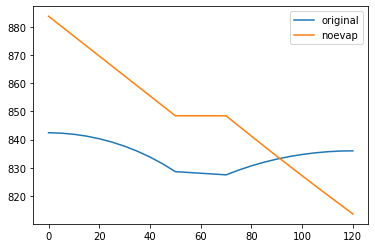

In [24]:
plt.plot(distance,tempx,label='original')
plt.plot(distance,tempx2,label='noevap')
plt.legend()

In [22]:
for i in range(10,12):
    plt.plot(plot_holder[i],label=value_array[i])
plt.legend()

NameError: name 'plot_holder' is not defined

In [ ]:
# KNOW THAT IT BREAKS AT ABOUT Qtotal = 13060.

In [ ]:
pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk = fluid_properties(800)
print(pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk)

In [ ]:
pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk = fluid_properties(1073.15)
print(pv, rho_l, mu_l, mu_v, sig, hfg, rho_v, cfluid, mw, rk)

In [ ]:
fmt = '{:{f}}  {:{f}} {:{f}}'
for i in range(total_mesh):
    print(fmt.format(distance[i],tempx[i],q1_array[i], f='8.2f'))

In [ ]:
plt.plot(distance,tempx)

In [ ]:
q1_array

In [ ]:
distance

In [ ]:
dpv_total

In [ ]:
pvap

In [ ]:
dpi_array

In [ ]:
dpv_array

In [ ]:
dpa_array

In [ ]:
dpl_array